In [1]:
import numpy as np

import albumentations as A
import cv2
from matplotlib import pyplot as plt
import os
import pandas as pd
import torch
import torchvision

from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from torchvision import transforms as T
from tqdm.notebook import tqdm
from typing import Callable, Iterable, List, Optional, Tuple, Union

In [2]:
DATA_DIR = Path('/media/dmitry/data/global-wheat-detection')

In [3]:
df = pd.read_csv(DATA_DIR/'train.csv')

In [4]:
df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [5]:
# image_id = str(df.loc[0, 'image_id'])
image_id = str(df.iloc[0, 0])
path = DATA_DIR/'train'/(image_id + '.jpg')
print(path)
# Image.open(path)

/media/dmitry/data/global-wheat-detection/train/b6ab77fd7.jpg


In [6]:
image = cv2.imread(str(path), cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [7]:
img_annots = df[df['image_id'] == image_id]
img_annots.head(3)

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1


In [8]:
def draw_boxes(image: np.ndarray, bboxes: Iterable[np.ndarray]):
    for bb in bboxes:
        bb = bb[:4]
        assert len(bb) == 4
        if isinstance(bb, tuple):
            bb = tuple(map(int, bb))
        elif isinstance(bb, np.ndarray):
            bb = bb.astype(int)
        cv2.rectangle(image, tuple(bb[:2]), tuple(bb[2:]), (255, 0, 0), 1)

In [9]:
def make_dataset(image_dir: str, files: Iterable[str]) -> List[str]:
    image_dir = os.path.expanduser(image_dir)

    if not os.path.isdir(image_dir):
        raise RuntimeError("Unable to read folder {}".format(image_dir))

    images = [os.path.join(image_dir, f) for f in files]
    return images


def cv2_imread(path: Union[str, Path]) -> np.ndarray:
    image = cv2.imread(str(path), cv2.IMREAD_COLOR)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def read_bbox(bbox: str, bbox_format='pascal_voc') -> Tuple[int]:
    bb = map(float, bbox[1:-1].split(','))
    bb = list(map(int, bb))

    if len(bb) < 4:
        raise ValueError("Dumb bbox: {}".format(bbox))

    # 0 is a label
    if bbox_format == 'coco':
        bb = tuple(bb + [0])
    elif bbox_format == 'pascal_voc':
        x0, y0, w, h = bb
        bb = (x0, y0, x0 + w, y0 + h, 0)
    else:
        raise NotImplementedError(bbox_format)

    return bb


def bbox_str_to_numpy(bbox: str) -> np.ndarray:
    return np.array(read_bbox(bbox), dtype=np.uint16)

In [10]:
class WheatDataset(Dataset):
    def __init__(self, image_dir, csv, transforms=None, show_progress=True):
        # type: (str, str, Optional[Transforms], Optional[bool]) -> WheatDataset
        super(WheatDataset, self).__init__()
        self.transforms = transforms

        df = pd.read_csv(csv)
        ids = df['image_id'].unique()
        files = map(lambda x: x + '.jpg', ids)
        self.images = make_dataset(image_dir, files)

        if show_progress:
            ids = tqdm(ids, desc="Parsing bboxes...")

        bboxes = []
        for image_id in ids:
            image_bb = df.loc[df['image_id'] == image_id, 'bbox']
            image_bb = np.stack(list(map(bbox_str_to_numpy, image_bb)))
            bboxes.append(image_bb)

        assert len(bboxes) == len(self.images)
        self.bboxes = bboxes

    def __getitem__(self, index):
        path = self.images[index]

        if not os.path.exists(path):
            log.warning("Unable to read from {}".format(path))
            index = np.random.randint(len(self))
            # Bad luck :) Lets make another dice roll...
            return self[index]

        image = cv2_imread(path)
        bboxes = self.bboxes[index]

        if self.transforms is not None:
            out = self.transforms(image=image, bboxes=bboxes)
            image, bboxes = out['image'], out['bboxes']
            bboxes = np.stack(bboxes)
        else:
            image = torch.from_numpy(image)
            bboxes = torch.from_numpy(bboxes)

        # Remove class label and downcast from float64 to int16
        # to send less data to GPU. Some boxes have fractional part of .5,
        # but for high res images this shouldn't be an issue
        bboxes = bboxes[:, :4].astype(np.int16)
        return image, bboxes

    def __len__(self):
        return len(self.images)

In [11]:
tfms = [
    A.Flip(),
    A.RandomRotate90(),
    A.Resize(512, 512, interpolation=cv2.INTER_AREA)
]

tfms = A.Compose(tfms, bbox_params=A.BboxParams('pascal_voc'))

In [12]:
%%time

image_dir = DATA_DIR/'train'
csv_path = DATA_DIR/'train.csv'

ds = WheatDataset(image_dir, csv_path, transforms=tfms)


CPU times: user 25.7 s, sys: 104 ms, total: 25.9 s
Wall time: 22.9 s


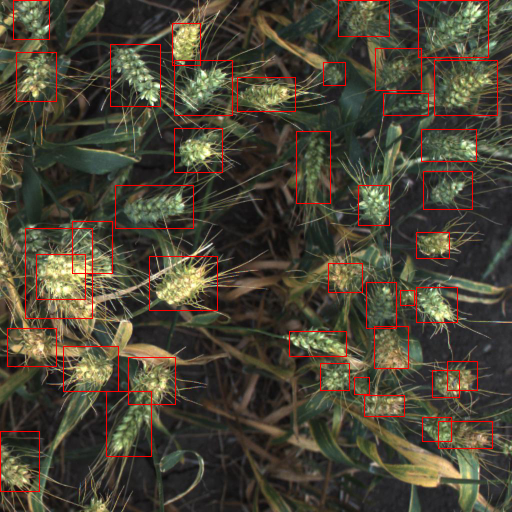

In [13]:
image, bboxes = ds[2]
draw_boxes(image, bboxes)
Image.fromarray(image)

In [14]:
def collate(batch):
    images, targets = tuple(zip(*batch))
    secret_sauce = torch.utils.data._utils.collate.default_collate
    images = secret_sauce(images)
    targets = list(map(secret_sauce, targets))
    return images, targets

In [15]:
dl = torch.utils.data.DataLoader(ds, batch_size=8, shuffle=True, collate_fn=collate)

In [16]:
images, targets = next(iter(dl))

images.shape, len(targets), targets[0].shape

(torch.Size([8, 512, 512, 3]), 8, torch.Size([40, 4]))